In [1]:
from IPython.display import display, HTML, Audio
display(HTML("<style>.container {width: 100%; important! }</style>"))
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [2]:
fname_1 = 'original_sound/borya_Karim.wav'
fname_2 = 'original_sound/motivation_Aynur.wav'
fs, audio_in_1 = wavfile.read(fname_1)
fs, audio_in_2 = wavfile.read(fname_2)

In [3]:
if audio_in_1.shape[0] > audio_in_2.shape[0]:
    audio_in_2 = np.concatenate((np.zeros(audio_in_1.shape[0] - audio_in_2.shape[0]), audio_in_2))
else:
    audio_in_1 = np.concatenate((np.zeros(audio_in_2.shape[0] - audio_in_1.shape[0]), audio_in_1))

In [4]:
unmixed = np.vstack([audio_in_1, audio_in_2])
unmixed = unmixed - np.expand_dims(unmixed.mean(1), axis=1)
unmixed = unmixed/np.expand_dims(np.std(unmixed, axis=1), axis=1)

In [5]:
unmixed.mean(1)

array([-1.55080729e-17, -4.69309352e-18])

In [6]:
np.std(unmixed, axis=1)

array([1., 1.])

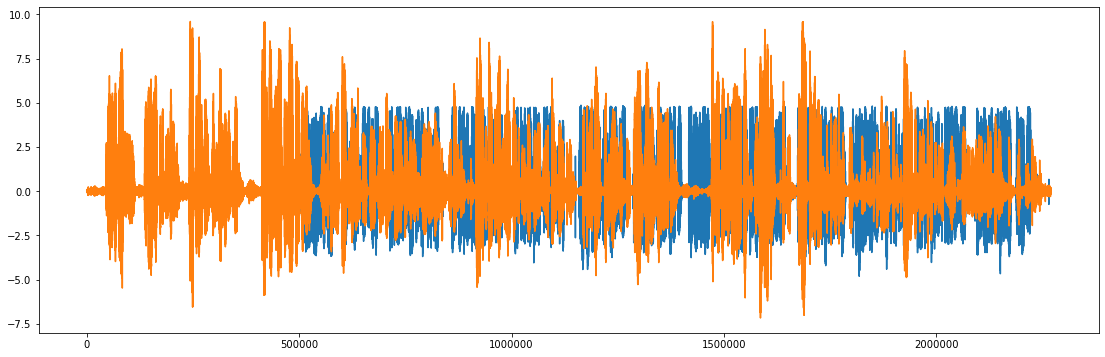

In [7]:
plt.figure(figsize=(19,6))
plt.plot(unmixed[0])
plt.plot(unmixed[1])

In [8]:
fs

44100

In [9]:
np.log10(unmixed.shape[1])

6.35582396856629

In [10]:
mixture_matrix = np.array([[2.1, 1], [1.2, 1.7]])
# mix_list = [mixture_matrix[0,0]*unmixed[0,:-1*10**0] + mixture_matrix[0,1]*unmixed[1,1*10**0:],
#             mixture_matrix[1,0]*unmixed[0,1*10**0:] + mixture_matrix[1,1]*unmixed[1,:-1*10**0]]
mix_list = [mixture_matrix[0,0]*unmixed[0] + mixture_matrix[0,1]*unmixed[1],
            mixture_matrix[1,0]*unmixed[0] + mixture_matrix[1,1]*unmixed[1]]
mixed = np.array(mix_list)

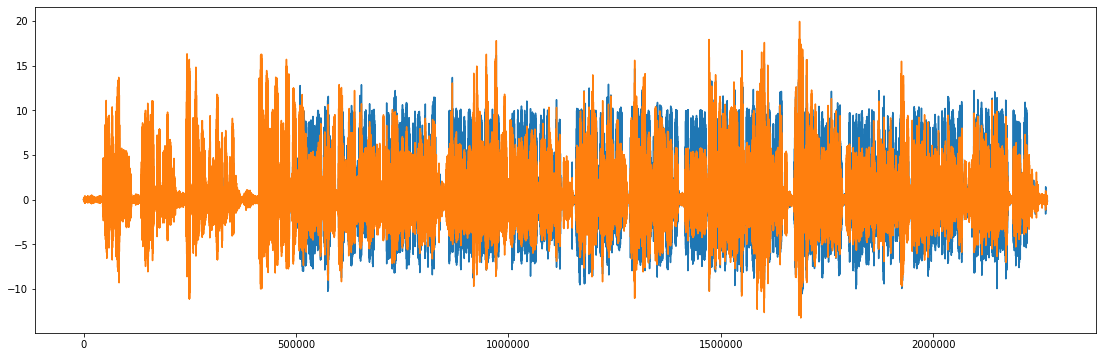

In [11]:
plt.figure(figsize=(19,6))
plt.plot(mixed[0])
plt.plot(mixed[1])

## Preprocessing

In [12]:
def center(signal):
    return signal - np.expand_dims(signal.mean(axis=1), axis=1)

def white(signal):
    matrix = np.cov(signal)
    w, E = np.linalg.eig(matrix)
    D = np.sqrt(np.linalg.pinv(np.diag(w)))
    M = E @ D @ E.T
    return M @ signal

def preprocess(signal):
    return white(center(signal))

In [13]:
print(np.linalg.inv(mixture_matrix))

[[ 0.71729958 -0.42194093]
 [-0.50632911  0.88607595]]


In [14]:
preprocessed = preprocess(mixed)

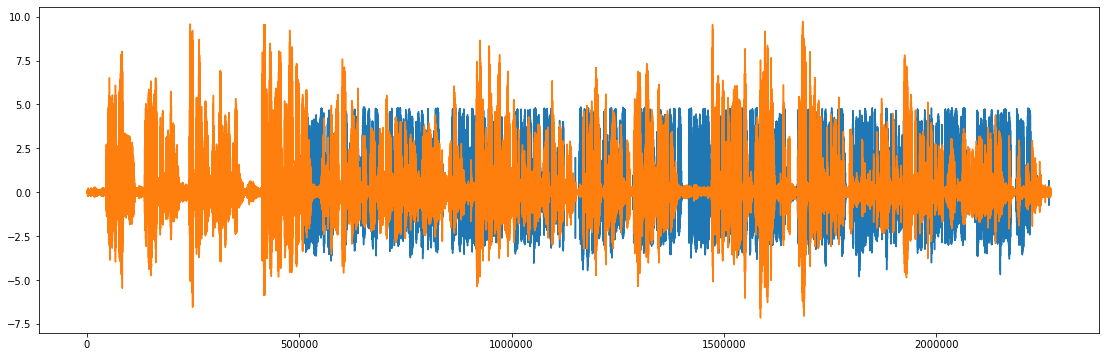

In [15]:
plt.figure(figsize=(19,6))
plt.plot(preprocessed[0])
plt.plot(preprocessed[1])

In [16]:
def derivG2(u):
    return u*np.exp(-(1/2)*u**2)

In [17]:
def deriv_deriv_G(u):
    return (1 - u**2)*np.exp(-(1/2)*u**2)

In [18]:
def converge_criterium(prev_w, curr_w, eps=0.01):
    if np.abs(prev_w.T@curr_w) < (1 - eps):
        return True
    else:
        return False
    

In [19]:
deriv_deriv_G(5)

-8.94396761298881e-05

In [20]:
curr_w = np.random.rand(mixed.shape[0])
prev_w = np.random.rand(mixed.shape[0])
curr_w = curr_w / np.linalg.norm(curr_w)
prev_w = prev_w / np.linalg.norm(prev_w)

In [21]:
converge_criterium(prev_w, curr_w)

False

In [22]:
# prev_v = curr_w.copy()


In [23]:
curr_w.T@mixed

array([-0.00079678, -0.00079678, -0.00079678, ...,  0.00808945,
       -0.00559476, -0.24161589])

In [24]:
(mixed @ derivG2(curr_w.T @ mixed)) / mixed.shape[1]

array([0.23008897, 0.21061272])

In [25]:
# curr_w = (mixed @ derivG2(curr_w.T @ mixed)) / mixed.shape[1] - curr_w*(deriv_deriv_G(curr_w.T @ mixed)).mean()
# curr_w = curr_w / np.linalg.norm(curr_w)

In [26]:
eps = 10**-9

In [27]:
while converge_criterium(prev_w, curr_w, eps):
    prev_w = curr_w.copy()
    curr_w = (((preprocessed @ derivG2(curr_w.T @ preprocessed)) / preprocessed.shape[1]) 
              - curr_w*(deriv_deriv_G(curr_w.T @ preprocessed)).mean())
    curr_w = curr_w / np.linalg.norm(curr_w)

In [28]:
prev_w.T@curr_w

-0.9999999991554895

In [36]:
unmixture_matix = np.linalg.inv(mixture_matrix)

In [39]:
unmixture_matix

array([[ 0.71729958, -0.42194093],
       [-0.50632911,  0.88607595]])

In [35]:
curr_w

array([ 0.05372514, -0.99855576])

In [30]:
res = curr_w.T@preprocessed
# res = np.linalg.inv(mixture_matrix)[:,0].T@preprocessed
res = res/np.abs(res).max()
res = (res*32767).astype(np.int16)
wavfile.write('once_ch_unmix_bor_mot_lag_res.wav', rate=fs, data=res)

In [31]:
Audio("once_ch_unmix_bor_mot_lag_res.wav")

In [32]:
# wavfile.write('once_ch_unmix_bor_mot_lag_res.wav', rate=fs, data=res)

In [33]:
# res = curr_w.T@preprocessed
# res = np.linalg.inv(mixture_matrix)[:,0].T@preprocessed
# res = res/np.abs(res).max()
# res = (res*32767).astype(np.int16)
# wavfile.write('once_ch_unmix_bor_mot_lag_res.wav', rate=fs, data=res)

In [34]:
# res.shape